In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestRegressor

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rc('font', family='AppleGothic') # 애플 폰트 사용
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 안깨지게 설정

In [27]:
test = pd.read_csv("../../data/raw/test.csv")
train = pd.read_csv("../../data/raw/train.csv")

In [28]:
test.head()

,ID,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원)
0,TEST_0000,2002,CT010,핀테크,Series C,3261.0,No,Yes,45.0,5021.0,6680.0,2.00,1500-2500
1,TEST_0001,2020,CT001,푸드테크,Series C,3707.0,Yes,No,70.0,1601.0,4654.0,4.20,NaN
2,TEST_0002,2014,CT006,에듀테크,IPO,236.0,Yes,Yes,89.0,4709.0,9289.0,1.00,6000이상
3,TEST_0003,2003,CT001,에너지,Seed,637.0,Yes,Yes,17.0,2145.0,7005.0,5.00,1500-2500
4,TEST_0004,2006,CT010,핀테크,Seed,4922.0,Yes,No,68.0,4995.0,7593.0,4.36,NaN


In [29]:
train.head()

,ID,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률
0,TRAIN_0000,2009,CT005,이커머스,Series A,4126.0,No,No,56.0,3365.0,4764.0,4.71,NaN,0.3
1,TRAIN_0001,2023,CT006,핀테크,Seed,4167.0,Yes,No,80.0,4069.0,279.0,1.00,2500-3500,0.8
2,TRAIN_0002,2018,CT007,기술,Series A,3132.0,Yes,Yes,54.0,6453.0,12141.0,4.00,3500-4500,0.5
3,TRAIN_0003,2016,CT006,NaN,Seed,3245.0,Yes,Yes,NaN,665.0,10547.0,2.97,NaN,0.7
4,TRAIN_0004,2020,CT002,에듀테크,Seed,1969.0,No,Yes,94.0,829.0,9810.0,1.00,1500-2500,0.1


# EDA

In [30]:
train.describe()

,설립연도,직원 수,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),성공확률
count,4376.000000,4202.000000,3056.000000,4376.000000,4376.000000,4376.000000,4376.000000
mean,2012.006856,2471.324369,49.214332,3314.568556,6452.202239,2.578103,0.537340
std,6.554872,1446.064215,27.141242,1880.103831,3782.792656,1.414590,0.241698
min,2001.000000,5.000000,1.000000,12.000000,12.000000,0.000000,0.100000
25%,2006.000000,1218.250000,27.000000,1651.500000,3094.250000,1.320000,0.400000
50%,2012.000000,2472.000000,49.000000,3398.000000,6478.500000,2.835000,0.600000
75%,2018.000000,3727.500000,72.000000,4908.250000,9692.500000,4.000000,0.700000
max,2023.000000,4998.000000,99.000000,7059.000000,14822.000000,5.000000,0.900000


In [31]:
train.isna().sum()

ID                   0
설립연도                 0
국가                   0
분야                 857
투자단계                 0
직원 수               174
인수여부                 0
상장여부                 0
고객수(백만명)          1320
총 투자금(억원)            0
연매출(억원)              0
SNS 팔로워 수(백만명)       0
기업가치(백억원)         1220
성공확률                 0
dtype: int64

In [32]:
train.isna().sum() / len(train)
# 각 컬럼별 결측치 비율

ID                0.000000
설립연도              0.000000
국가                0.000000
분야                0.195841
투자단계              0.000000
직원 수              0.039762
인수여부              0.000000
상장여부              0.000000
고객수(백만명)          0.301645
총 투자금(억원)         0.000000
연매출(억원)           0.000000
SNS 팔로워 수(백만명)    0.000000
기업가치(백억원)         0.278793
성공확률              0.000000
dtype: float64

---
### 1. 고객수(백만명)의 count가 다른 컬럼보다 적다.   
### 2. SNS 팔로워 수(백만명) 의 값이 0 인 부분은 결측치로 본다 -> 스타트업 기준 가장 기본적인 홍보 방법이 sns로 판단함
### 3. 연매출, 투자금을 사용해 수익성 분석을 시도할수있음.

파생 변수 만들어볼만한듯?  
1. 기엽_연령 : 신뢰도, 생존력 -> 얼마나 사업이 안정적인지? - 기준은 2025년으로 한다.  
    ( 어느 년도를 기준으로 계산할지 문의를 남겼지만 알아서 판단하라고 답장옴. )

3. 직원당 매출 : 생산성 -> 사람 1명당 얼마나 벌어들이는지를 의미, 효율성이 높을수록 기업 체계가 잘 잡혔다
4. 고객당 매출 : 고객 질 -> 수익성을 나타냄
5. 투자단계 : 성장 단계 -> 투자단계 차제가 시업 성장의 척도이다. 뒤로 갈수록 검증된 기업이라는 의미 (순서형 변수로 인코딩)
6. 인수여부_x_투자단계 : 어느 투자 단계에서 인수했는지? -> 초기단계에 인수될수록 수익성 높은 사업이라고 판단함

파생변수는 먼저 전처리를 한 뒤에 피처중요도로 판단하자!

In [33]:
train['설립연도'].describe()

count    4376.000000
mean     2012.006856
std         6.554872
min      2001.000000
25%      2006.000000
50%      2012.000000
75%      2018.000000
max      2023.000000
Name: 설립연도, dtype: float64

In [34]:
# 2001 ~ 2023년까지 빠진 년도있나 확인
year = train['설립연도'].unique()
year.sort()
print(year)

[2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2022 2023]


누락된 연도 없이 모두 잘 포함됨. 결측치 없음을 확인하고 그대로 모델에 입력 예정

In [35]:
train['국가'].unique()
# 국가코드는 공식으로 사용하는 문자가 아닌 따로 사용하는 비공식적인 코드로 보임
# 결측치 없음, 범주형 인코딩(원 핫 인코딩) 사용 예정
# 데이터의 순서가 없음으로 원 핫 인코딩 사용으로 결정

array(['CT005', 'CT006', 'CT007', 'CT002', 'CT008', 'CT010', 'CT001',
       'CT009', 'CT003', 'CT004'], dtype=object)

In [36]:
print(f"분야의 결측치 비율 : {(train['분야'].isnull().sum() / len(train['분야'])) * 100:.2f}%")

분야의 결측치 비율 : 19.58%


In [37]:
train['분야'].unique()
# 결측치 비율이 20%임. -> 적은 수준인가? -> 적은 수준이라고 판단함.
# 숫자형이 아니므로 Unknown으로 대체할 예정임
# 마찬가지로 순서가 없기 때문에 One Hot encoding으로 할 예정
# 컬럼이 너무 많이 생기는거 아닌가? -> 컬럼이 총 11개 생성되지만 모델 학습에 큰 영향은 없다고 개인적인 판단
# 30 ~ 50 개 부터 문제 생김

array(['이커머스', '핀테크', '기술', nan, '에듀테크', '게임', '헬스케어', '물류', '푸드테크', 'AI',
       '에너지'], dtype=object)

In [38]:
train['투자단계'].unique()
# 투자 단계는 결측치가 없음
# 이건 순서가 있으니 Label encoding 가능한가? -> 직접 맵핑하자
# Seed : Series A : Series B : Series C : IPO 순서로 나열 가능함?
# Label encoding 문제점이 있는걸로 보임 -> Oridinal Encoding 비교해봐야할듯 
# 모델에 따라 인코딩이 달라질듯

array(['Series A', 'Seed', 'Series C', 'Series B', 'IPO'], dtype=object)

In [39]:
train['인수여부'].unique()
# 범주형임 One-hot encoding
# 결측치도 없다.
# 투자단계와 파생변수를 만들기

array(['No', 'Yes'], dtype=object)

In [40]:
train['상장여부'].unique()
# 범주형인 One-hot encoding

array(['No', 'Yes'], dtype=object)

In [41]:
train['총 투자금(억원)']
# 결측치도 없고 깔끔한 수치형 데이터인듯
# 굳이 float으로 처리해야하나? 정수형이 더 적은 메모리 사용?

0       3365.0
1       4069.0
2       6453.0
3        665.0
4        829.0
         ...  
4371    4187.0
4372     796.0
4373    3314.0
4374    2395.0
4375     903.0
Name: 총 투자금(억원), Length: 4376, dtype: float64

In [42]:
# 소수점 이하가 0이 아닌 값의 개수
# 없으니깐 그냥 정수형처리로 한다.
count = (train["총 투자금(억원)"] % 1 != 0).sum()
print(count)

0


In [43]:
train['연매출(억원)']
# 결측치도 없고 깔끔한 수치형
# 정수형으로 변환 고민?

0        4764.0
1         279.0
2       12141.0
3       10547.0
4        9810.0
         ...   
4371     9394.0
4372     2969.0
4373     4512.0
4374     3755.0
4375     9417.0
Name: 연매출(억원), Length: 4376, dtype: float64

In [44]:
# 정수로 변환 확정
count = (train['연매출(억원)']%1 != 0).sum()
print(count)

0


In [45]:
train['SNS 팔로워 수(백만명)'].describe()

count    4376.000000
mean        2.578103
std         1.414590
min         0.000000
25%         1.320000
50%         2.835000
75%         4.000000
max         5.000000
Name: SNS 팔로워 수(백만명), dtype: float64

In [46]:
train['기업가치(백억원)'].unique()

array([nan, '2500-3500', '3500-4500', '1500-2500', '4500-6000', '6000이상'],
      dtype=object)

In [47]:
train['성공확률']
# 사용 모델에 따라 스케일링 해야할듯

0       0.3
1       0.8
2       0.5
3       0.7
4       0.1
       ... 
4371    0.8
4372    0.4
4373    0.6
4374    0.9
4375    0.6
Name: 성공확률, Length: 4376, dtype: float64

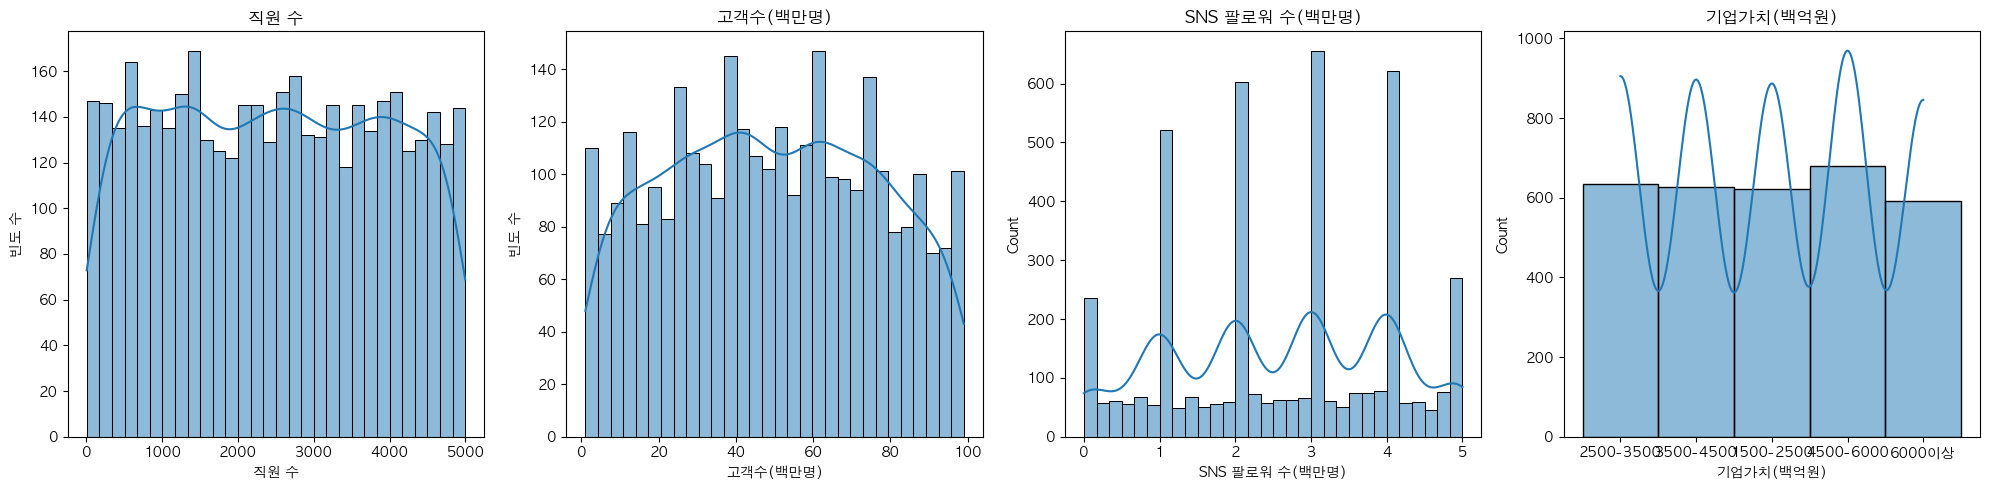

In [48]:
# 서브플롯 설정
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1행 3열

# 직원 수
sns.histplot(train['직원 수'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('직원 수')
axes[0].set_xlabel('직원 수')
axes[0].set_ylabel('빈도 수')

# 고객수(백만명)
sns.histplot(train['고객수(백만명)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("고객수(백만명)")
axes[1].set_ylabel('빈도 수')

# SNS 팔로워 수(백만명)
sns.histplot(train['SNS 팔로워 수(백만명)'], bins=30, kde=True, ax=axes[2])
axes[2].set_title("SNS 팔로워 수(백만명)")

#기업가치(백억원)
sns.histplot(train['기업가치(백억원)'], bins=30, kde=True)
axes[3].set_title('기업가치(백억원)')
plt.tight_layout()
plt.show


# 시각화 결과 저장
plt.savefig('../../src/histograms.png', dpi=300, bbox_inches='tight')

plt.show()

위에 그래프는 결측치를 어떻게 처리할지 판단을 위한 그래프임  
직원 수는 데이터가 평균을 이루며 고르게 분포되어있다. -> 평균으로 대체  
고객수(백만명)은 데이터가 중앙으로 몰림. -> 중앙값으로 대체  
SNS 팔로워수는 인위적인 데이터로 보임 최빈값으로 대체  
기업가치는 최빈값으로 대체

# 데이터 전처리 전략 정리

---
## 📌 설립연도
- **타입**: 수치형 (정수형)
- **결측치**: 없음
- **처리 전략**: 그대로 모델에 사용
- **비고**: 기업 나이 등 파생변수도 추후 고려 가능

---

## 📌 국가
- **타입**: 범주형 (코드형 문자열)
- **결측치**: 없음
- **처리 전략**: 원-핫 인코딩 (One-Hot Encoding)
- **비고**: 사람이 읽을 수 있는 국가명이 아닌 코드로 표현됨

---

## 📌 분야
- **타입**: 범주형
- **결측치**: 있음 → `'Unknown'`으로 대체
- **처리 전략**: 원-핫 인코딩
- **비고**: 고유값이 많으면 top-N 인코딩 고려 가능

---

## 📌 투자단계
- **타입**: 범주형 (순서형)
- **결측치**: 없음
- **처리 전략**: 명확한 순서가 있으니 직접 숫자를 매핑
- **비고**: **모델 종류에 따라 인코딩 전략 달라질 수 있음**

---

## 📌 직원 수
- **타입**: 수치형 (float → int 가능)
- **결측치**: 낮은 비율 → 평균으로 대체
- **분포**: 균등 분포, 이상치 없음, 대칭적
- **처리 전략**: `평균(mean)`으로 대체
- **비고**: 필요시 정수형으로 타입 캐스팅 고려

---

## 📌 인수여부
- **타입**: 범주형 (예/아니오 또는 Y/N)
- **결측치**: 없음
- **처리 전략**: 원-핫 인코딩

---

## 📌 상장여부
- **타입**: 범주형 (상장 / 비상장)
- **결측치**: 없음
- **처리 전략**: 원-핫 인코딩

---

## 📌 고객수 (백만명)
- **타입**: 수치형 (float)
- **결측치**: 많음 (약 30%)
- **분포**: 중앙값 주변에 밀집됨
- **처리 전략**: `중앙값(median)`으로 대체
- **비고**: 로그 변환, 구간화 등 추가 전처리 가능

---

## 📌 총 투자금 (억원)
- **타입**: 수치형 (float)
- **결측치**: 없음
- **처리 전략**: 그대로 사용
- **비고**: `int` 형 변환 시 메모리 최적화 가능

---

## 📌 연매출 (억원)
- **타입**: 수치형 (float)
- **결측치**: 없음
- **처리 전략**: 그대로 사용
- **비고**: `int` 형 변환 시 메모리 최적화 가능

---

## 📌 SNS 팔로워 수 (백만명)
- **타입**: 수치형 (정수 느낌의 분포)
- **결측치**: 있음
- **분포**: 인위적으로 구간화된 듯한 분포
- **처리 전략**: `최빈값(mode)`으로 대체

---

## 📌 기업가치 (백억원)
- **타입**: 범주형 (구간 문자열)
- **결측치**: 많음
- **처리 전략**: 
  - 상황에 따라 `'Unknown'` 또는 
  - 평균 구간 추정 기반으로 대체
- **비고**: 수치화해서 분석 가능. 순서형 변수로 사용 가능

# 파생변수 생성 및 전처리 함수

In [49]:
def preprocess(df):
    """
    주어진 데이터프레임에 대해 전처리 수행:
    - 결측치 처리
    - 인코딩
    - 매핑
    - 형변환 등
    """
    # 1. 설립연도: 그대로 사용 (패스)

    # 2. 국가: 원핫 인코딩
    df = pd.get_dummies(df, columns=['국가'])

    # 3. 분야: 결측치 → 'Unknown', 원핫 인코딩
    df['분야'].fillna('Unknown', inplace=True)
    df = pd.get_dummies(df, columns=['분야'])

    # 4. 투자단계: 수동 매핑
    investment_stage_order = {
        'Seed': 0,
        'Series A': 1,
        'Series B': 2,
        'Series C': 3,
        'IPO': 4
    }
    df['투자단계'] = df['투자단계'].map(investment_stage_order)

    # 5. 직원 수: 평균으로 대체
    mean_emp = df['직원 수'].mean()
    df['직원 수'].fillna(mean_emp, inplace=True)

    # 6. 인수여부, 상장여부: 원핫 인코딩
    df = pd.get_dummies(df, columns=['인수여부', '상장여부'])

    # 7. 고객수: 중앙값으로 대체
    median_cust = df['고객수(백만명)'].median()
    df['고객수(백만명)'].fillna(median_cust, inplace=True)

    # 8. 총 투자금, 연매출: 정수형 변환
    df['총 투자금(억원)'] = df['총 투자금(억원)'].astype(int)
    df['연매출(억원)'] = df['연매출(억원)'].astype(int)

    # 9. SNS 팔로워 수: 최빈값으로 대체
    mode_sns = df['SNS 팔로워 수(백만명)'].mode()[0]
    df['SNS 팔로워 수(백만명)'].fillna(mode_sns, inplace=True)

    # 10. 기업가치: 결측치 보완 + 수치 매핑
    df['기업가치(백억원)'].fillna('4500~6000', inplace=True)
    value_map = {
        '1500~2500': 2000,
        '2500~3500': 3000,
        '3500~4500': 4000,
        '4500~6000': 5250,
        '6000이상': 6500
    }
    df['기업가치(백억원)'] = df['기업가치(백억원)'].map(value_map)
    df['기업가치(백억원)'].fillna(5250, inplace=True)  # 매핑 실패 보완

    return df

def add_features(df):
    # 1. 기업나이
    df['기업나이'] = 2025 - df['설립연도']

    # 2. 직원당 매출
    df['직원당매출'] = df['연매출(억원)'] / df['직원 수'].replace(0, np.nan)

    # 3. 고객당 매출
    df['고객당매출'] = df['연매출(억원)'] / df['고객수(백만명)'].replace(0, np.nan)

    # 4. 투자수익비
    df['투자수익비'] = df['연매출(억원)'] / df['총 투자금(억원)'].replace(0, np.nan)

    # 5. SNS 팔로워 등급
    df['SNS팔로워등급'] = pd.cut(df['SNS 팔로워 수(백만명)'],
                             bins=[-1, 1, 3, 10],
                             labels=['낮음', '중간', '높음'])

    # 6. 가치대비매출 (기업가치 결측치 처리 포함)
    df['가치대비매출'] = df['기업가치(백억원)'] / df['연매출(억원)'].replace(0, np.nan)

    # 7. 총투자금당직원수
    df['총투자금당직원수'] = df['직원 수'] / df['총 투자금(억원)'].replace(0, np.nan)

    return df

# 파생변수 생성